<b>Welcome to the Image Transfer Learning tutorial!</b>

Today you will try out one of the most cutting-edge image recognition models in the industry and train some of your own as well. 

This tutorial is adapted from the examples at https://keras.io/applications/. You can find out more after the session.

If you are not using the docker image we provide, let's first install the packages we need.

In [1]:
# We use Keras with the Tensforflow backend to train the models. 
# If pip doesn't work well for you, please install Anaconda and use conda to install tensorflow instead.
!pip install tensorflow
!pip install keras

In [2]:
# We use pydot and graphviz for visualizing the model structure.
!pip install pydot
!pip install graphviz

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
from matplotlib.pyplot import imshow
from imageio import imread
import numpy as np
import tensorflow as tf

Download the data from http://download.tensorflow.org/example_images/flower_photos.tgz with the following command: <br>
`curl -LO http://download.tensorflow.org/example_images/flower_photos.tgz` <br>
And then, please decompress it to the path `data/flower_photos/train`. Note that this will take a while. If you use the docker image we provide, the data should have already been downloaded and extracted for you. Please go to `data/flower_photos/train` to make sure the data is organized correctly like the following, each class with its own subcategory. :
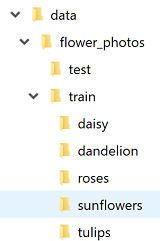
In the 'data/flower_photos/train' folder, you can put any images you like to test the models you will train today.

We first define the parameters for training. We have already talked about them in the presentation just now. Do you recognize them?

In [4]:
# dimensions of our images. 
img_width, img_height = 224, 224 
# If you put the ta in a different path from what is shown above, you should change the path here as well.
train_data_dir = 'data/flower_photos/train' 
epochs = 5 # about 3-5 min per epoch on cpu without multi-threading
batch_size = 32
steps_per_epoch = 25
val_step = 3

To make the results easier to read, we provide a helper function to map the scores to the class names.

In [5]:
class_names = ['rose', 'tulip', 'daisy', 'dandelion', 'sunflower']
class_names = sorted(class_names) # Sorting them

def prob_to_class(class_names, probs):
    return dict(zip(class_names, probs.ravel().tolist()))

<b>Exercise 1: Play with the original Inception v3 model from Google </b>

In [6]:
#load the full InceptionV3 model
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet', include_top=True)

Using TensorFlow backend.


The next cell will plot the model structure out for your reference. Isn't it a deep model?! 

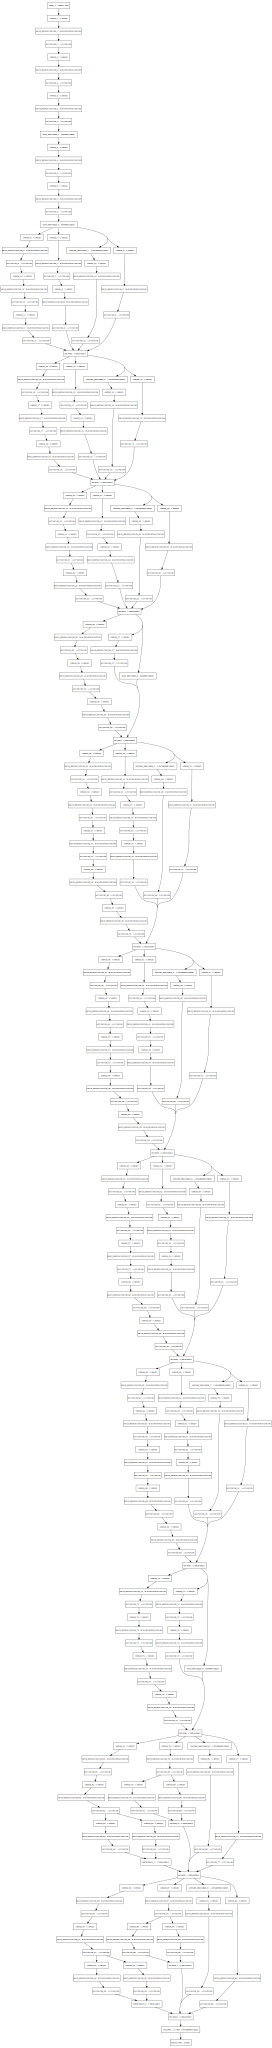

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

We provide a helper function to make it easier to test on one image. Can you tell what the function does before calling `model.predict()` to calculate the results?

In [8]:
#test on one image
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

def test_one_image(img_path, target_w, target_h, model):
    img = image.load_img(img_path, target_size=(target_w, target_h))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    return preds

Let's test the model on a daisy image we found on the Internet. It worked!

Predicted: [[('n11939491', 'daisy', 0.96190333), ('n03991062', 'pot', 0.0200659), ('n04522168', 'vase', 0.016221913), ('n03482405', 'hamper', 0.0005655474), ('n07930864', 'cup', 0.00050525006)]]


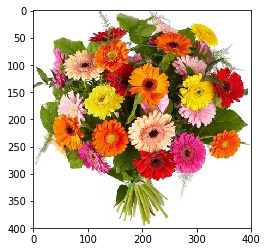

In [9]:
from keras.applications.imagenet_utils import decode_predictions

test_image = 'data/flower_photos/test/1.jpg'
imshow(imread(test_image))
result = test_one_image(test_image, img_width, img_height, model)
print('Predicted:', decode_predictions(result))

Now it's your turn! Test an image you select with the model to see if it works.

In [10]:
# Your code here

<b>Exercise 2: Use transfer learning to retrain the model for flowers</b>

You probably have noticed that the Inception model covers many different classes, but it doesn't include many detailed classes about flowers. This is because it is trained with the ImageNet data, which consists of over 14 million images in 21841 classes. It also includes 462 classes of different flowers, but the accuracy is not always that great. Now we will use the data we downloaded to see if we can train a different model with transfer learning to achieve a better accuracy on the 5 types of flowers that we are particularly interested in. 

In [11]:
# create the base pre-trained model
from keras.layers import Input, Dense, GlobalAveragePooling2D

base_model = InceptionV3(include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 5 classes
predictions = Dense(5, activation='softmax')(x)

In [12]:
# prepare training and validation dataset
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    train_data_dir,  # this is where the data is
    target_size=(img_width, img_height),  # all images will be resized
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_data_dir,  # this is where the data is
    target_size=(img_width, img_height),  # all images will be resized
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [13]:
# this is the model we will train
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics

new_model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                  metrics=[metrics.mae, metrics.categorical_accuracy])

callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto'), 
             TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)]

# train the model on the new data for a few epochs
history = new_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                  callbacks=callbacks, verbose=1,
                                  validation_data=val_generator, validation_steps=val_step)

new_model.save_weights('first_try.h5')  # always save your weights after training or during training


Epoch 1/5
25/25 [==============================] - 394s 16s/step - loss: 3.9949 - mean_absolute_error: 0.2693 - categorical_accuracy: 0.3812 - val_loss: 2.4348 - val_mean_absolute_error: 0.2551 - val_categorical_accuracy: 0.3438
Epoch 2/5
25/25 [==============================] - 444s 18s/step - loss: 1.2783 - mean_absolute_error: 0.2122 - categorical_accuracy: 0.5513 - val_loss: 2.5665 - val_mean_absolute_error: 0.2179 - val_categorical_accuracy: 0.4792


The training will take a while. We can use tensorboard --logdir=./logs to visualize the training process. It seems that it starts to overfit around epoch 3. We can enable early stopping.

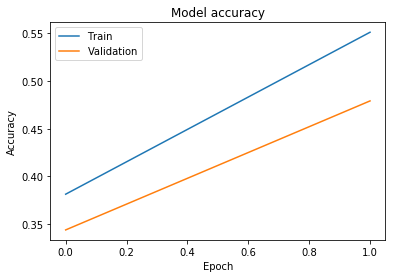

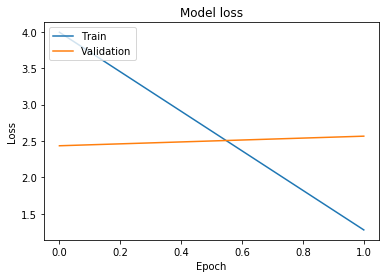

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Now it's the time to test our model! Does it work better than the original Inception model on the flowers we are interested in?

Predicted: {'daisy': 0.9974405765533447, 'dandelion': 0.00048190055531449616, 'rose': 0.0001499622012488544, 'sunflower': 0.0016480260528624058, 'tulip': 0.0002795950567815453}


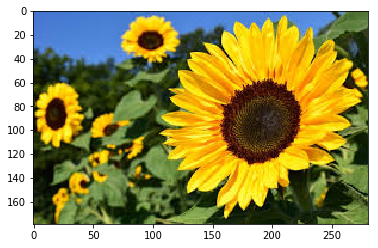

In [15]:
test_image = 'data/flower_photos/test/2.jpg'
imshow(imread(test_image))
result = test_one_image(test_image, img_width, img_height, new_model)
print('Predicted:', prob_to_class(class_names, result))

In [16]:
# Your code here to test more images.

<b>Exercise 3: Fine tue the model </b>

It seems that the model doesn't perform that well. This is because we are only training the last layer. Now we will fine tune more layers to select the most suitable features for our purpose.

In [17]:
# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. 
# We will freeze the bottom N layers and train the remaining top layers.

fine_tune_model = Model(inputs=base_model.input, outputs=predictions)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [18]:
# we chose to train the top 2 inception blocks, i.e. we will freeze the first 172 layers and unfreeze the rest:
layer_split_idx = 172

for layer in fine_tune_model.layers[:layer_split_idx]:
   layer.trainable = False
for layer in fine_tune_model.layers[layer_split_idx:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD

fine_tune_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',
                        metrics=[metrics.mae, metrics.categorical_accuracy])

# we train our model again (this time fine-tuning the top 2 inception blocks alongside the top Dense layers
history2 = fine_tune_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                                         callbacks=callbacks, verbose=1,
                                         validation_data=val_generator, validation_steps=val_step)

fine_tune_model.save_weights('fine_tune.h5')  # save your weights after training

# The training will be slower than the process one, because we train much more layers therefore much more parameters. 

Epoch 1/5
25/25 [==============================] - 566s 23s/step - loss: 0.8971 - mean_absolute_error: 0.1729 - categorical_accuracy: 0.6562 - val_loss: 0.8065 - val_mean_absolute_error: 0.1742 - val_categorical_accuracy: 0.7292
Epoch 2/5
25/25 [==============================] - 547s 22s/step - loss: 0.6663 - mean_absolute_error: 0.1542 - categorical_accuracy: 0.7728 - val_loss: 0.5953 - val_mean_absolute_error: 0.1458 - val_categorical_accuracy: 0.7912
Epoch 3/5
25/25 [==============================] - 529s 21s/step - loss: 0.6153 - mean_absolute_error: 0.1485 - categorical_accuracy: 0.7950 - val_loss: 0.6976 - val_mean_absolute_error: 0.1570 - val_categorical_accuracy: 0.7604


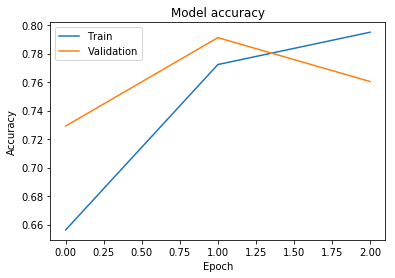

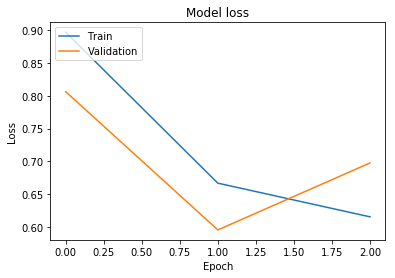

In [19]:
# Plot training & validation accuracy values
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Now let's test the fine-tuned model.

Predicted: {'daisy': 0.0679328665137291, 'dandelion': 0.0560811422765255, 'rose': 0.013855157420039177, 'sunflower': 0.8390676975250244, 'tulip': 0.02306307666003704}


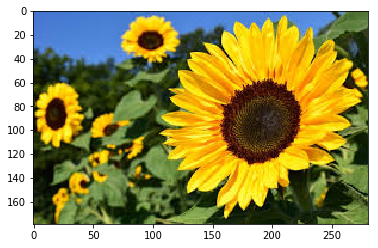

In [20]:
test_image = 'data/flower_photos/test/2.jpg'
imshow(imread(test_image))
result = test_one_image(test_image, img_width, img_height, fine_tune_model)
print('Predicted:', prob_to_class(class_names, result))

In [21]:
# Your code here to test more images.

In [22]:
from keras.utils import print_summary
print_summary(fine_tune_model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

<b>Optional Exercise: Train with a different dataset</b>

Congratulations! You have learned how to train a deep neural network for image recognition with transfer learning. Now you can use the similar method to trian on your own dataset. Here are some open datasets available online:
* cat

In [24]:
# Your code here.

<b>Optional Exercise: Change the training parameters</b>

Can you use different parameters to train the model, so that the result is better and/or faster? Here are some ideas:
* how many data is reserved for validation
* how many layers to freeze
* a different optimizer such as RMSprop or Adam
* different learning rate

In [23]:
# Your code here